# How not to do machine learning: prediction of protein folding rates

A widely used Python package for ML is `sklearn`. Already familiar `pandas` and `matplotlib` will also be needed. Biopython package is needed for biological data processing.

In [1]:
from Bio.PDB import PDBParser
from Bio.PDB.DSSP import *
p = PDBParser()

import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
pd.options.display.max_columns = 40
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from scipy import stats

In [2]:
# settings for fancy plots

sns.set(context="notebook", font_scale=1.3)
sns.set_style('whitegrid')
plt.rcParams["figure.figsize"] = (8,5)

## 1. Data processing

The dataset provided to you is already preprocessed (initially it contained only folding rates, sequences, pdbs and omegas).

The processed dataset includes calculated features for amino acid composition and secondary structure. The first one is derived by dividing the occurance of a particular amino acid by sequence length. The second - with the help of DSSP (for each pdb the number of amino acids of a particular secondary structure type are counted and then divided by the sequence length). In addition, the categorial variable kinetic order is [encoded](https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02) (0 for order higher than two, 1 - for kinetic order equal to two).

In [3]:
# import the dataset

data = pd.read_csv('fr_proc.csv')
data

,id,name,pdb,length,ln_kf,order,sequence,-,H_dssp,T_dssp,S_dssp,I_dssp,E_dssp,G_dssp,B_dssp,N,L,Y,I,Q,W,K,D,G,P,S,R,A,M,E,F,V,T,H,C,order_encoded,omega
0,1,Trp-cage protein,1L2Y,20,12.5,two,NLYIQWLKDGGPSSGRPPPS,0.300000,0.350000,0.150000,0.000000,0.0,0.000000,0.200000,0.000000,0.050000,0.100000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.150000,0.200000,0.150000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,-0.14
1,2,Alanine-based peptide,0,21,15.5,two,AAAAAAAARAAAARAAAARAA,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.857143,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1,2.43
2,3,Villin headpeace subdomain,1VII,36,9.4,two,MLSDEDFKAVFGMTRSAFANLPLWKQQNLKKEKGLF,0.194444,0.527778,0.166667,0.111111,0.0,0.000000,0.000000,0.000000,0.055556,0.138889,0.000000,0.000000,0.055556,0.027778,0.138889,0.055556,0.055556,0.027778,0.055556,0.027778,0.083333,0.055556,0.055556,0.111111,0.027778,0.027778,0.000000,0.000000,1,0.83
3,4,Peripheral subunit-binding domain,2PDD,41,9.8,two,AMPSVRKYAREKGVDIRLVQGTGKNGRVLKEDIDAFLAGGA,0.243902,0.463415,0.170732,0.097561,0.0,0.000000,0.000000,0.000000,0.024390,0.073171,0.024390,0.048780,0.024390,0.000000,0.097561,0.073171,0.146341,0.024390,0.024390,0.097561,0.121951,0.024390,0.048780,0.024390,0.097561,0.024390,0.000000,0.000000,1,0.23
4,5,GA module of albumin binding domain,1PRB,47,13.8,two,LKNAiEDAIAELKKAGITSDFYFNAINKAKTVEEVNALvNEILKAHA,0.127660,0.680851,0.106383,0.085106,0.0,0.000000,0.000000,0.000000,0.106383,0.085106,0.021277,0.106383,0.000000,0.000000,0.127660,0.042553,0.021277,0.000000,0.021277,0.000000,0.191489,0.000000,0.106383,0.042553,0.063830,0.042553,0.021277,0.000000,1,0.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,110,p19INK4d (61),1BD8,166,2.2,multi,mlleevRAGDRLSGAAARGDVQEVRRLLHRELVHPDALNRFGKTAL...,0.228916,0.500000,0.138554,0.066265,0.0,0.000000,0.000000,0.000000,0.018072,0.150602,0.000000,0.018072,0.048193,0.000000,0.018072,0.072289,0.090361,0.042169,0.042169,0.072289,0.126506,0.024096,0.054217,0.024096,0.096386,0.054217,0.048193,0.000000,0,1.46
110,111,Apoflavodoxin (Anabaena sp.) (64),1FTG,169,0.8,two,sKKIGLFYGTQTGKTESVAEIIRDEFGNDVVTLHDVSQAEVTDLND...,0.177515,0.272189,0.195266,0.065089,0.0,0.218935,0.071006,0.000000,0.047337,0.088757,0.047337,0.065089,0.053254,0.023669,0.059172,0.118343,0.112426,0.005917,0.065089,0.023669,0.047337,0.000000,0.065089,0.047337,0.059172,0.059172,0.005917,0.005917,1,-1.57
111,112,sIGPS (67),1IGS,222,-7.8,multi,QRPIISLNERILEFNKRNITAIIAEYKRKSPSGLDVERDPIEYSKF...,0.220721,0.387387,0.112613,0.067568,0.0,0.166667,0.027027,0.018018,0.063063,0.112613,0.036036,0.130631,0.013514,0.000000,0.067568,0.045045,0.045045,0.031532,0.085586,0.072072,0.049550,0.022523,0.121622,0.031532,0.045045,0.027027,0.000000,0.000000,0,0.61
112,113,Carbonic anhydrase (68),1V9E,260,-4.2,multi,MSHHWGYGKHNGPEHWHKDFPIANGERQSPVDIDTKAVVQDPALKP...,0.257692,0.069231,0.130769,0.142308,0.0,0.288462,0.092308,0.011538,0.050000,0.100000,0.030769,0.019231,0.046154,0.026923,0.069231,0.073077,0.076923,0.073077,0.061538,0.034615,0.065385,0.015385,0.042308,0.042308,0.076923,0.053846,0.042308,0.000000,0,-0.03


The target (predicted) variable and the features should be stored in separate variables. Ensure you have not included the column with values to be predicted into features, otherwise, you will get perfect prediction and 100% accuracy :)

We will try to predict the folding rates with and without information on secondary structure and will check whether adding of additional features increases the prediction accuracy. We will refer to the full set of features (with secondary structure information) as `x_add_ft`.

In [4]:
# defining a function for separating target variable and features

def data_split(data):    
    y = data['ln_kf']
    x_add_ft = data.drop(columns=['ln_kf', 'id', 'name', 'pdb', 'sequence', 'order', 'order_encoded'])
    x_aa_only = data.drop(columns=['ln_kf', 'id', 'name','sequence', 'pdb', 'order', 'order_encoded', '-',
     'H_dssp',
     'T_dssp',
     'S_dssp',
     'I_dssp',
     'E_dssp',
     'G_dssp',
     'B_dssp'])
    return x_add_ft,y,x_aa_only

In [5]:
x_add_ft,y,x_aa_only = data_split(data)

In [6]:
x_aa_only.head(2)

,length,N,L,Y,I,Q,W,K,D,G,P,S,R,A,M,E,F,V,T,H,C,omega
0,20,0.05,0.1,0.05,0.05,0.05,0.05,0.05,0.05,0.15,0.2,0.15,0.050000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.14
1,21,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.142857,0.857143,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.43


In [7]:
x_add_ft.head(2)

,length,-,H_dssp,T_dssp,S_dssp,I_dssp,E_dssp,G_dssp,B_dssp,N,L,Y,I,Q,W,K,D,G,P,S,R,A,M,E,F,V,T,H,C,omega
0,20,0.3,0.35,0.15,0.0,0.0,0.0,0.2,0.0,0.05,0.1,0.05,0.05,0.05,0.05,0.05,0.05,0.15,0.2,0.15,0.050000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.14
1,21,0.0,1.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.142857,0.857143,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.43


In [8]:
y

0      12.5
1      15.5
2       9.4
3       9.8
4      13.8
       ... 
109     2.2
110     0.8
111    -7.8
112    -4.2
113     6.0
Name: ln_kf, Length: 114, dtype: float64

In [9]:
for i in [x_add_ft,x_aa_only,y]:
    print(i.shape)

(114, 30)
(114, 22)
(114,)


In [20]:
# splitting a dataset into training and testing sets (60% training, 40% testing)
# Let's firstly try with x_aa_only set

x_train, x_test, y_train, y_test = train_test_split(x_aa_only, y, test_size=0.4)

## 2. Building a model

In [21]:
# 1. creating a linear regression model 
model = LinearRegression()

# 2. fitting training data to the model
model.fit(x_train, y_train)

# 3. predicting the folding rates with features used for training and unseen data (test set)
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

# 4. validating the predictions made by model
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
print('Coefficient of determination training set ' + ': %.2f' % r2_train)
print('Coefficient of determination testing set ' + ': %.2f' % r2_test)

Coefficient of determination training set : 0.64
Coefficient of determination testing set : 0.45


At this point you may put in your CV that you have experience in working with artificial intelligence ;) Now we will go in more details and figure out why machine learning have not solved all problems of humanity yet.

The model above predicted the folding rates with 64% accuracy (coefficient of determination) on training set and 45% on unseen data - not perfect but seems promissing. However, if you try different splitting for training and testing sets you will see that every time the model delivers different inconsistent and sometimes inadequate results (negative [r2 score from sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) denotes that <s>everything is very sad</s> your model is worse than a model making predictions with no regard to input features).

Below all the ML procedures are arranged in one pipeline. Random state is set for the reproducability of results - with a defined random state at the step of dataset splitting you will get the same results every time. You may state your lucky number.

In [22]:
# arranging all steps in a pipeline

def lm(x,y, rs):
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state = rs)
    
    model = LinearRegression()
    model.fit(x_train, y_train)
    
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)
    
    
    def print_scores(y, y_pred, dataset):
        mse = mean_squared_error(y, y_pred)
        r2 = r2_score(y, y_pred)
        print('Coefficient of determination on ' + dataset + ': %.2f' % r2)
        print('Mean squared error on ' + dataset + ': %.2f' % mse)
    
    print_scores(y_train, y_pred_train, 'train')
    print_scores(y_test, y_pred_test, 'test')

In [23]:
lm(x_aa_only, y, 18)

Coefficient of determination on train: 0.60
Mean squared error on train: 5.61
Coefficient of determination on test: 0.50
Mean squared error on test: 13.64


In [24]:
# hmm, adding features improves accuracy for training but not testing set...

lm(x_add_ft, y, 18)

Coefficient of determination on train: 0.67
Mean squared error on train: 4.63
Coefficient of determination on test: 0.34
Mean squared error on test: 18.06


In [25]:
# play with different random states

meow = 21
lm(x_aa_only, y, meow)
lm(x_add_ft, y, meow)

Coefficient of determination on train: 0.67
Mean squared error on train: 7.48
Coefficient of determination on test: 0.25
Mean squared error on test: 11.19
Coefficient of determination on train: 0.74
Mean squared error on train: 5.73
Coefficient of determination on test: 0.22
Mean squared error on test: 11.54


## 3. Validating a model using learning curves

[Learning curve](https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/) is a plot of model learning performance over experience (e.g. size of a dataset) or time. It is a useful approach to diagnost the problems with machine learning model -plotted metrics averaged through several runs is more indicative than a single correlation coeffiecient or p-value.

We will fit the model with the increasing number of data points (starting from a dataset size of let's say 35 with step 1 till the full dataset of 114) - the coefficient of determination (squared Pearson correlation coefficient) between the predicted and observed log folding rates is calculated 1000 times for a model trained on a dataset of size in range of 35 to 114 and the averaged value is plotted as a function of the dataset size, together with the standard deviations of both sets.

Basically, we randomly take 35 data entries from the initial dataset, divide it to training and testig set in a ratio 60%:40%, fit this data to the model and calculate the coefficient between the predicted folding rate and observed one. We repeat this procedure 1000 times, calculate the average coefficient and the standard deviation. The same procedure is then applied to a dataset of 36, 37 ... 113, 114.

[Machine Learning: How Much Does It Tell about Protein Folding Rates?](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4659572/)

In [26]:
def learning_curve(data,N,add_ft=False):
    
    min_size = 35 # the minimal size of a dataset, starting point
    r2_train = np.zeros((N, data.shape[0]-min_size))
    r2_test = np.zeros((N, data.shape[0]-min_size))
    
    for row in range(N):
        #print(row)
        for i, df_size in enumerate(range(min_size, data.shape[0])):
            
            x_add_ft,y,x_aa_only = data_split(data.sample(n = df_size)) # extracting a portion of size n from initial dataset. starting from n = 35
            
            # using either limited set of features or full (without or with secondary structure information)
            if add_ft == False:
                x_train, x_test, y_train, y_test = train_test_split(x_aa_only, y, test_size=0.4)
            elif add_ft == True:
                x_train, x_test, y_train, y_test = train_test_split(x_add_ft, y, test_size=0.4)

            model = LinearRegression()
            model.fit(x_train, y_train)

            y_pred_train = model.predict(x_train)
            y_pred_test = model.predict(x_test)
            
            def scores(y, y_pred):
                r2 = stats.pearsonr(y,y_pred)[0]**2
                return r2
            
            r2_train[row][i] = scores(y_train, y_pred_train)
            r2_test[row][i] = scores(y_test, y_pred_test)
            
    return r2_train, r2_test

In [31]:
%%time

# this will take some time...
r2_train, r2_test = learning_curve(data, 1000, add_ft=False)
r2_train_add_ft, r2_test_add_ft = learning_curve(data, 1000, add_ft=True)

Wall time: 45min 38s


In [32]:
# purely technical stuff. calculating averaged correlation coefficients and standard deviations and writing the values to an array
def r2_avr_std(array):
    array_avr = np.zeros((array.shape[1]))
    array_std = np.zeros((array.shape[1]))
    for i in range(array.shape[1]):
        avr = np.mean(array[:,i])
        std = np.std(array[:,i])
        array_avr[i] = avr
        array_std[i] = std
    return array_avr, array_std

In [33]:
r2_train_avr, r2_train_std = r2_avr_std(r2_train)
r2_test_avr, r2_test_std = r2_avr_std(r2_test)
r2_train_avr_af, r2_train_std_af = r2_avr_std(r2_train_add_ft)
r2_test_avr_af, r2_test_std_af = r2_avr_std(r2_test_add_ft)

In [34]:
# plotting a learning curve

def lc_plot(r2_train_avr, r2_train_std, r2_test_avr, r2_test_std, title):
    
    plt.rcParams["figure.figsize"] = (7,4)
    
    x = np.arange(35,114)
    
    fig, ax = plt.subplots()
    
    ax.plot(x,r2_train_avr, label='train')
    ax.plot(x,r2_test_avr, label='test')
    ax.fill_between(x, r2_train_avr - r2_train_std, r2_train_avr + r2_train_std, alpha=0.2)
    ax.fill_between(x, r2_test_avr - r2_test_std, r2_test_avr + r2_test_std, alpha=0.2)   
    plt.xlim(35,114)
    
    ax.set_xlabel('Dataset size')
    ax.set_ylabel('R2 score')
    ax.set_title(title)
    plt.legend(loc='lower right')
    plt.show()

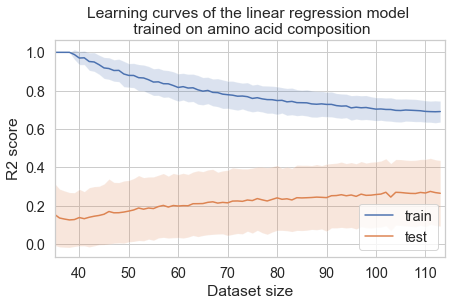

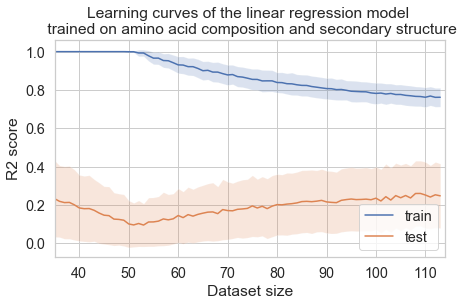

In [40]:
lc_plot(r2_train_avr, r2_train_std, r2_test_avr, r2_test_std, title = 'Learning curves of the linear regression model \n trained on amino acid composition')
lc_plot(r2_train_avr_af, r2_train_std_af, r2_test_avr_af, r2_test_std_af, title = 'Learning curves of the linear regression model \n trained on amino acid composition and secondary structure')

>As the sample size increases, there are more points to fit in the training set with the same number of parameters, so the explained variance decreases (blue). Meanwhile, the model becomes more general and acquires more predictive power on new data, so the explained variance on the testing set increases (red). The gap (vertical distance) between the two curves shows the extent of overfitting, or in other words the lack of fit of the model when confronted with new data. When the two curves meet, the model is not overfitted and the true predictive power is the value of the common asymptote. Note that for consistency with the previous sections, we plotted the correlation coefficient instead of the more common R2. The two lines do not converge, even when all the data points available are included, which means that there is presently not enough experimental data to properly train the complete model.

What is observed from the learnin curves:

1. The gap between the training and test curves indicate overfitting.
2. Adding features increases the accuracy for the traing set but not for unseen data. It usually happens when the added features don't correlate with the target. However, in our case it is probably due to a small size of the dataset - the contribution of the secondary structure information can't be estimated with such sparse data.  

If we fit a model with the sequence length as the only feature according to the nucleation-based model $\ln(k_{f}) \propto -L^{2/3}$, the learning curve will show that the variances on the training and test sets are indistinguishable, which means that the model is not overfitted. However, the performance is still poor.

In [41]:
def learning_curve_23(data,N):
    
    min_size = 35
    r2_train = np.zeros((N, data.shape[0]-min_size))
    r2_test = np.zeros((N, data.shape[0]-min_size))
    #print(r2_train.shape, r2_test.shape)
    
    for row in range(N):
        #print(row)
        for i, df_size in enumerate(range(min_size, data.shape[0])):
            
            df = data.sample(n = df_size)
            x = df.loc[:,['length']]**(2/3)
            y = df['ln_kf']
            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4)

            model = LinearRegression()
            model.fit(x_train, y_train)

            y_pred_train = model.predict(x_train)
            y_pred_test = model.predict(x_test)
            
            def scores(y, y_pred):
                r2 = stats.pearsonr(y,y_pred)[0]**2
                return r2         
                
            r2_train[row][i] = scores(y_train, y_pred_train)
            r2_test[row][i] = scores(y_test, y_pred_test)
            
    return r2_train, r2_test

In [43]:
%%time
r2_train_23, r2_test_23 = learning_curve_23(data, 1000)

Wall time: 11min 20s


In [44]:
r2_train_avr_23, r2_train_std_23 = r2_avr_std(r2_train_23)
r2_test_avr_23, r2_test_std_23 = r2_avr_std(r2_test_23)

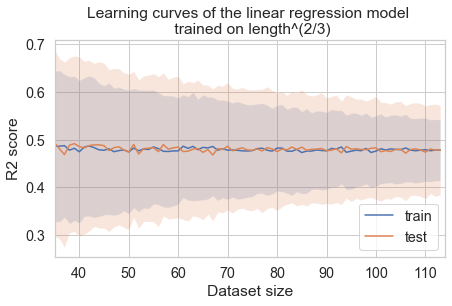

In [45]:
lc_plot(r2_train_avr_23, r2_train_std_23, r2_test_avr_23, r2_test_std_23, title = 'Learning curves of the linear regression model \n trained on length^(2/3)')

## Conclusions

### Protein folding rates

Low amount of experimental data on protein folding rates makes the use of machine learning for prediction of this parameter not reliable. 

The lack of experimental data on the rate of protein folding is such that model fitting suffers large fluctuations, even for models with few parameters. Low amount of experimental data currently prohibits discovering more subtle determinants of protein folding rates by statistical and machine-learning methods.

It can be formulated alternatively - with currently available experimental data the best result for ML approach is that observed on the learning curves.

### General

1. Use <s>every computational tool</s> machine learning wisely. Think carefully if you really need it.
2. Validate the model comprehensively.